# Applied Data Science Capstone Week 3: Segmenting and Clustering Neighborhoods in Toronto

## Load Required Packages

In [15]:
! pip install geocoder wikipedia folium yellowbrick

import wikipedia as wiki                          # extracting postal code data
import numpy as np                                # number crunching
import pandas as pd                               # creating and working with data frames
# import geocoder                                 # extracting latitute and longitude
import copy                                       # deep copying variables
import folium                                     # map visualization
import requests                                   # pulling data from Foursquare

import matplotlib.cm as cm                        # visualizations
import matplotlib.colors as colors                # visualizations

from sklearn.preprocessing import StandardScaler  # normalizing for k-clustering
from sklearn.cluster import KMeans                # k-clustering
from sklearn.datasets import make_blobs           # k-clustering
from yellowbrick.cluster import KElbowVisualizer  # matplotlib wrapper for visualizing the k-clustering elbow
from geopy.geocoders import Nominatim             # for looking up latitude and longitute of city (Toronto) from name



In [16]:
%matplotlib inline 

## Part 1: Preparing Initial Dataframe

### 1.1 Pull Wikipedia Data

In [17]:
pageTitle = 'List of postal codes of Canada: M'
html = wiki.WikipediaPage(title=pageTitle).html()

### 1.2 Clean and test dataframe

In [18]:
# Format Dataframe
df_tables = pd.read_html(html) # dataframe of tables on the Wikipedia page
df_postCodes = df_tables[0]    # we want the first result
df_postCodes = df_postCodes.query('Borough != "Not assigned"')  #filter out "Not assigned"

# Merge neighbourhoods sharing a postal code
nhood_concat = lambda a: ", ".join(a)
df_postCode = df_postCodes.groupby(by=['Postcode', 'Borough']).agg({'Neighbourhood': nhood_concat}).reset_index()

# Find all instances where Neighbourhood == 'Not assigned' and replace 'Not assigned' with the Borough
idx = df_postCode.index[df_postCode['Neighbourhood'] == "Not assigned"].tolist()
for x in idx:
    # Column Indicies: 0 = Postcode, 1 = Borough, 2 = Neighbourhood
    df_postCode.iloc[x, 2] = df_postCode.iloc[x, 1]

# Check
print("Are all values unique? ",df_postCode['Postcode'].nunique() == df_postCode['Postcode'].count())

df_postCode

Are all values unique?  True


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


### 1.3 Display data frame row count

In [19]:
# Shape of Output Table
rowCount = df_postCode.shape[0]
print("There are {} rows in the dataframe".format(rowCount))

There are 103 rows in the dataframe


### Question 2: Latitude and Longitude Data Frame

In [20]:
# Attempt using Geocoder method timed out
#
# Initialize variables
# latLong = None

#df_postCode_latLong = df_postCode.copy(deep=True)

#for postal_code in df_postCode_latLong['Postcode']:
#    while (latLong is None):
#        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#        latLong = g.latlng
#    
#    df_postCode_latLong['Latitude'] = copy.deepcopy(latLong[0])
#    df_postCode_latLong['Longitiude'] = copy.deepcopy(latLong[1])

#df_postCode_latLong

### 2.1 Import latitute and longitude data

In [21]:
!wget -O geoData.csv https://cocl.us/Geospatial_data
df_postCode_latLongB = df_postCode.copy(deep=True)
df_latLong = pd.read_csv('geoData.csv')
df_latLong.head()

--2020-02-07 01:39:08--  https://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 158.85.108.83, 169.48.113.194, 158.85.108.86
Connecting to cocl.us (cocl.us)|158.85.108.83|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-07 01:39:10--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.27.197, 107.152.26.197
Connecting to ibm.box.com (ibm.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2020-02-07 01:39:11--  https://ibm.box.com/public/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/9afzr83pps4pwf2sm

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### 2.2 Align Column Names Before Merge, then merge existing dataframe with dataframe containing latitude and longitute

In [22]:
df_latLong.rename(columns={'Postal Code' : 'PostCode'}, inplace=True) 
df_postCode_latLongB.rename(columns={'Postcode' : 'PostCode'}, inplace=True)

df_postCode_latLongB = pd.merge(df_postCode_latLongB, df_latLong, on='PostCode')

### 2.3 Display Result

In [23]:
df_nhoods = df_postCode_latLongB
df_nhoods.head()

,PostCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Question 3: Clustering the Neighbourhoods of Toronto

### 3.1 Build Map of Toronto

In [24]:
# Find Toronto's Latitude and Longitude using Nominatim
location = Nominatim(user_agent='CourseraCourse9').geocode('Toronto')
lat = location.latitude
long = location.longitude

print("Toronto's geographical coordinates are : {}, {}".format(lat, long))

Toronto's geographical coordinates are : 43.653963, -79.387207


In [25]:
# Creating a map of Toronto using folium
TOmap = folium.Map(location=[lat,long], zoom_start=11)

# add markers to map
for lat, lng, borough, neighbourhood, pc in zip(df_nhoods['Latitude'], df_nhoods['Longitude'], df_nhoods['Borough'], df_nhoods['Neighbourhood'], df_nhoods['PostCode']):
    label = '{}: {}, {}'.format(pc, neighbourhood, borough)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='white',
        fill_opacity=0.7).add_to(TOmap)  
    
TOmap

#### 3.2 Pull Data From Foursquare
##### Foursquare Credentials

In [26]:
# The code was removed by Watson Studio for sharing.

#### Code for pulling nearby venues:

In [27]:
def getNearbyVenues(postcode, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for pc, name, lat, lng in zip(postcode, names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            pc,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostCode', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [28]:
# Pull Data
TOvenues = getNearbyVenues(postcode=df_nhoods['PostCode'], names=df_nhoods['Neighbourhood'], latitudes=df_nhoods['Latitude'], longitudes=df_nhoods['Longitude'])

print(TOvenues.shape)
TOvenues.head()

(1333, 8)


,PostCode,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,M1C,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [50]:
# See how many venues types there are
print('There are {} venue types found in Toronto'.format(len(TOvenues['Venue Category'].unique())))

There are 233 venue types found in Toronto


### 3.3 Analyze Each Post Code

In [30]:
# one hot encoding
TOonehot = pd.get_dummies(TOvenues[['Venue Category']], prefix="", prefix_sep="")

# add PostCode column back to dataframe
TOonehot['PostCode'] = TOvenues['PostCode'] 

# move neighborhood column to the first column
fixed_columns = [TOonehot.columns[-1]] + list(TOonehot.columns[:-1])
TOonehot = TOonehot[fixed_columns]

TOonehot.head()

,PostCode,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M1C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M1E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Display mean frequency of each type of venue, by postal code prefix
TOgrouped = TOonehot.groupby('PostCode').mean().reset_index()
TOgrouped

,PostCode,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,M1C,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,M1E,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,M1G,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,M1H,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
5,M1J,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6,M1K,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
7,M1L,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
8,M1M,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
9,M1N,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


#### Display dataframe with 10 most common venues by postal code prefix

In [32]:
# function to find the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd'] # for labelling columns

# create columns according to number of top venues
columns = ['PostCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostCode'] = TOgrouped['PostCode']

for ind in np.arange(TOgrouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(TOgrouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,PostCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Fast Food Restaurant,Dessert Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
1,M1C,Bar,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
2,M1E,Pizza Place,Electronics Store,Breakfast Spot,Medical Center,Intersection,Mexican Restaurant,Rental Car Location,Dim Sum Restaurant,Eastern European Restaurant,Dumpling Restaurant
3,M1G,Coffee Shop,Korean Restaurant,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
4,M1H,Bank,Fried Chicken Joint,Hakka Restaurant,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bakery,Discount Store,Dim Sum Restaurant
5,M1J,Playground,Yoga Studio,Department Store,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop
6,M1K,Discount Store,Department Store,Coffee Shop,Convenience Store,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant
7,M1L,Bus Line,Bakery,Soccer Field,Ice Cream Shop,Park,Intersection,Bus Station,Ethiopian Restaurant,Empanada Restaurant,Electronics Store
8,M1M,Motel,American Restaurant,Dessert Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
9,M1N,College Stadium,General Entertainment,Skating Rink,Café,Dessert Shop,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


### 3.4 Clustering the Neighbourhoods

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


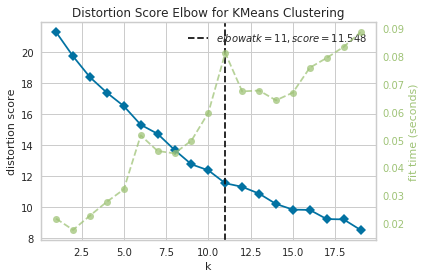

In [33]:
# Determine Optimal K value
cluster_count = 3

# run clustering
TOgrouped_clustering = copy.deepcopy(TOgrouped.drop('PostCode', 1))
kmeans = KMeans(init="k-means++", n_clusters=cluster_count, n_init=12)
kmeans_viz= KElbowVisualizer(kmeans, k=(1,20))

# Generate and display visualizer
kmeans_viz.fit(TOgrouped_clustering)
kmeans_viz.show()

Clustering plotted 10 times, k = 12 is most common elbow point
> 10	12	10	12	10	10	12	12	12	11

#### With the cluster count in mind, we can complete the model build

In [35]:
klusters = 12 # set number of clusters, best value as identified by graph generated in previous cells

TOgrouped_clustering = TOgrouped.drop('PostCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=klusters, random_state=0).fit(TOgrouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each PostCode
toronto_merged = pd.merge(neighborhoods_venues_sorted, df_nhoods, how='left', on='PostCode', validate='1:1') #toronto_merged.join(postcode_venues_sorted.set_index('PostCode'), on='PostCode')

# display preview of clustered data
toronto_merged.head()

,Cluster Labels,PostCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Neighbourhood,Latitude,Longitude
0,10,M1B,Fast Food Restaurant,Dessert Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,8,M1C,Bar,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,11,M1E,Pizza Place,Electronics Store,Breakfast Spot,Medical Center,Intersection,Mexican Restaurant,Rental Car Location,Dim Sum Restaurant,Eastern European Restaurant,Dumpling Restaurant,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,0,M1G,Coffee Shop,Korean Restaurant,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Scarborough,Woburn,43.770992,-79.216917
4,11,M1H,Bank,Fried Chicken Joint,Hakka Restaurant,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bakery,Discount Store,Dim Sum Restaurant,Scarborough,Cedarbrae,43.773136,-79.239476


In [36]:
# View postal code counts by cluster
# This demonstrates the most populous clusters, highlighting where we should focus our analysis
toronto_merged['Cluster Labels'].value_counts()

0     40
11    34
3      7
2      6
4      3
1      3
10     1
9      1
8      1
7      1
6      1
5      1
Name: Cluster Labels, dtype: int64

### The two most populous clusters (0, 11) contain 74% of all postal codes, and 87% of postal codes are captures in the top 4 clusters.
Therefore, examining the top cluster will provide a good overview of the most popular places in Toronto.

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]

,PostCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Neighbourhood,Latitude,Longitude
3,M1G,Coffee Shop,Korean Restaurant,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Scarborough,Woburn,43.770992,-79.216917
9,M1N,College Stadium,General Entertainment,Skating Rink,Café,Dessert Shop,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848
17,M2J,Clothing Store,Coffee Shop,Juice Bar,Thai Restaurant,Electronics Store,Japanese Restaurant,Salon / Barbershop,Burger Joint,Fast Food Restaurant,Liquor Store,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
18,M2K,Café,Japanese Restaurant,Chinese Restaurant,Bank,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,North York,Bayview Village,43.786947,-79.385975
20,M2N,Ramen Restaurant,Coffee Shop,Café,Sandwich Place,Grocery Store,Discount Store,Ice Cream Shop,Indonesian Restaurant,Electronics Store,Juice Bar,North York,Willowdale South,43.770120,-79.408493
24,M3B,Café,Gym / Fitness Center,Japanese Restaurant,Caribbean Restaurant,Dessert Shop,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,North York,Don Mills North,43.745906,-79.352188
25,M3C,Coffee Shop,Asian Restaurant,Beer Store,Gym,Italian Restaurant,Japanese Restaurant,Fast Food Restaurant,Discount Store,Dim Sum Restaurant,Supermarket,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923
26,M3H,Coffee Shop,Sushi Restaurant,Supermarket,Shopping Mall,Bridal Shop,Sandwich Place,Restaurant,Pizza Place,Pharmacy,Grocery Store,North York,"Bathurst Manor, Downsview North, Wilson Heights",43.754328,-79.442259
27,M3J,Coffee Shop,Massage Studio,Bar,Caribbean Restaurant,Falafel Restaurant,Yoga Studio,Diner,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,North York,"Northwood Park, York University",43.767980,-79.487262
32,M4A,Pizza Place,Coffee Shop,Portuguese Restaurant,Hockey Arena,Department Store,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,North York,Victoria Village,43.725882,-79.315572


In [46]:
# Second Most Populous Cluster
toronto_merged.loc[toronto_merged['Cluster Labels'] == 11, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]

,PostCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough,Neighbourhood,Latitude,Longitude
2,M1E,Pizza Place,Electronics Store,Breakfast Spot,Medical Center,Intersection,Mexican Restaurant,Rental Car Location,Dim Sum Restaurant,Eastern European Restaurant,Dumpling Restaurant,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
4,M1H,Bank,Fried Chicken Joint,Hakka Restaurant,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Gas Station,Bakery,Discount Store,Dim Sum Restaurant,Scarborough,Cedarbrae,43.773136,-79.239476
7,M1L,Bus Line,Bakery,Soccer Field,Ice Cream Shop,Park,Intersection,Bus Station,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
10,M1P,Indian Restaurant,Pet Store,Vietnamese Restaurant,Brewery,Chinese Restaurant,Dim Sum Restaurant,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Scarborough,"Dorset Park, Scarborough Town Centre, Wexford ...",43.757410,-79.273304
11,M1R,Middle Eastern Restaurant,Breakfast Spot,Sandwich Place,Bakery,Auto Garage,Yoga Studio,Diner,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Scarborough,"Maryvale, Wexford",43.750072,-79.295849
12,M1S,Latin American Restaurant,Lounge,Breakfast Spot,Skating Rink,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Scarborough,Agincourt,43.794200,-79.262029
13,M1T,Pizza Place,Pharmacy,Chinese Restaurant,Italian Restaurant,Gas Station,Noodle House,Fast Food Restaurant,Thai Restaurant,Bank,Fried Chicken Joint,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302
16,M2H,Golf Course,Fast Food Restaurant,Pool,Mediterranean Restaurant,Dog Run,Dessert Shop,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,North York,Hillcrest Village,43.803762,-79.363452
21,M2P,Park,Convenience Store,Electronics Store,Bank,Yoga Studio,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant,Eastern European Restaurant,North York,York Mills West,43.752758,-79.400049
33,M4B,Pizza Place,Fast Food Restaurant,Athletics & Sports,Pharmacy,Bus Line,Intersection,Bank,Pet Store,Gastropub,Gym / Fitness Center,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937


### Visualizing the clusters on a map

In [43]:
# create map
map_clusters = folium.Map(location=[lat, long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(klusters)
ys = [i + x + (i*x)**2 for i in range(klusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters